# CARS recommender system
Implementation of the deep NN model described in the paper "Context-Aware Recommendations Based on Deep
Learning Frameworks".
https://dl.acm.org/doi/10.1145/3386243

Datasets:
- frappe


## Import

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split # to split dataset in two parts
from sklearn.model_selection import KFold # to split dataset using  k-fold cross validation
from sklearn.metrics import * # evaluation metrics
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, BatchNormalization, Dropout, Input, Embedding, Flatten, Concatenate
from keras.optimizers import Adam
import matplotlib
import matplotlib.pyplot as plt # for creating chart
import requests # for downloading the dataset
from collections import deque # queue data structure
from scipy.cluster.hierarchy import * # for hierarchical clustering
from sklearn.cluster import AgglomerativeClustering
import itertools
from sklearn.decomposition import PCA



### Some functions



In [ ]:
# plot loss based on history of model.fit, ymin and ymax are the minimum and maximum values of the y axis
def plot_loss(history, ymin=0, ymax=1):
  plt.plot(history.history['loss'], label='loss')
  plt.ylim([ymin, ymax])
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)

# plot chart of true values on predictions
def plot_predictions(test_y, pred_y):
  a = plt.axes(aspect='equal')
  plt.scatter(test_y, pred_y)
  plt.xlabel('True Values')
  plt.ylabel('Predictions')
  lims = [0, 5]
  plt.xlim(lims)
  plt.ylim(lims)
  _ = plt.plot(lims, lims)

def sigmoid(x):
   return 1 / ( 1 + np.exp(-x))


## Dataset

### Load dataset

In [ ]:
# download the dataset
url = 'https://raw.githubusercontent.com/CriptHunter/tesi/master/CARS_DL/frappe/frappe.csv'
req = requests.get(url, allow_redirects=True)
open('frappe.csv', 'wb').write(req.content)

6313241

In [ ]:
# open the dataset
df = pd.read_csv('/content/frappe.csv', sep="\t")
df

,user,item,cnt,daytime,weekday,isweekend,homework,cost,weather,country,city
0,0,0,1,morning,sunday,weekend,unknown,free,sunny,United States,0
1,1,1,7,afternoon,saturday,weekend,unknown,free,cloudy,Spain,0
2,2,2,6,evening,monday,workday,unknown,free,cloudy,Spain,369
3,3,3,1,sunset,thursday,workday,unknown,free,unknown,United States,1028
4,4,4,428,night,thursday,workday,home,free,sunny,Switzerland,147
...,...,...,...,...,...,...,...,...,...,...,...
96198,110,0,5,evening,sunday,weekend,unknown,free,sunny,United States,0
96199,37,16,101,sunset,sunday,weekend,unknown,free,cloudy,Canada,128
96200,181,33,243,afternoon,sunday,weekend,unknown,free,cloudy,Israel,454
96201,451,752,1,evening,sunday,weekend,unknown,free,sunny,United States,0


In [ ]:
# count unique values for each column
display("------ unique values ------")
display(df.nunique())

# count number of unknown values for each column
display("------ unknown values ------")
display(df.isin(['unknown']).sum(axis=0))

# count number of zero values for each column (for city 0 == unknown)
display("------ zero values ------")
display(df.isin([0]).sum(axis=0))

'------ unique values ------'

user          957
item         4082
cnt          1981
daytime         7
weekday         7
isweekend       2
homework        3
cost            2
weather         9
country        80
city          233
dtype: int64

'------ unknown values ------'

user             0
item             0
cnt              0
daytime          0
weekday          0
isweekend        0
homework     75670
cost             0
weather      12529
country       7025
city             0
dtype: int64

'------ zero values ------'

user            25
item           521
cnt              0
daytime          0
weekday          0
isweekend        0
homework         0
cost             0
weather          0
country          0
city         38052
dtype: int64

### Dataset preprocessing

In [ ]:
# log transformation on the raw frequency numbers that represent the applications usage
df['cnt'] = df['cnt'].apply(np.log10)
f"frequency range is {df['cnt'][df['cnt'] == df['cnt'].min()].values[0]} to {df['cnt'][df['cnt'] == df['cnt'].max()].values[0]}"

# delete columns that are not needed
del df['homework']
del df['cost']
del df['city']
del df['isweekend']
del df['country']

In [ ]:
# delete rows where weather is unknown
df = df[df.weather != 'unknown']
df = df.reset_index(drop=True)

# make user and items id start from 0
df.user = pd.factorize(df.user)[0]
df.item = pd.factorize(df.item)[0]

df

,user,item,cnt,daytime,weekday,weather
0,0,0,0.000000,morning,sunday,sunny
1,1,1,0.845098,afternoon,saturday,cloudy
2,2,2,0.778151,evening,monday,cloudy
3,3,3,2.631444,night,thursday,sunny
4,4,4,0.778151,sunset,saturday,sunny
...,...,...,...,...,...,...
83669,96,0,0.698970,evening,sunday,sunny
83670,30,33,2.004321,sunset,sunday,cloudy
83671,156,26,2.385606,afternoon,sunday,cloudy
83672,399,672,0.000000,evening,sunday,sunny


In [ ]:
x_labels = ['user', 'item']
y_label = 'cnt'
context_labels = ['daytime', 'weekday', 'weather']

# convert categorical data to one-hot encoding
for col in context_labels:
  df = pd.get_dummies(df, columns=[col], prefix = [col])

# new context labels after one-hot encoding are columns from 3 to the end
context_labels = df.columns[3:]
df

,user,item,cnt,daytime_afternoon,daytime_evening,daytime_morning,daytime_night,daytime_noon,daytime_sunrise,daytime_sunset,weekday_friday,weekday_monday,weekday_saturday,weekday_sunday,weekday_thursday,weekday_tuesday,weekday_wednesday,weather_cloudy,weather_drizzle,weather_foggy,weather_rainy,weather_sleet,weather_snowy,weather_stormy,weather_sunny
0,0,0,0.000000,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
1,1,1,0.845098,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0
2,2,2,0.778151,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
3,3,3,2.631444,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
4,4,4,0.778151,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83669,96,0,0.698970,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
83670,30,33,2.004321,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
83671,156,26,2.385606,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
83672,399,672,0.000000,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1


In [ ]:
# k-fold cross validation object
kf = KFold(n_splits=3, random_state=42, shuffle=True)

def kfold_train(model, epochs, batch_size, verbose, df, x_labels, y_label, context_labels, kf):
    '''
    Train a model using K-fold CV

    Parameters:
        model: the model to be trained
        epochs: training epochs for each fold
        batch_size: batch size for each fold
        verbose: show training batch and loss
        df: the dataframe on which the model will be trained
        x_labels: features labels
        y_label: value to predict label
        context_labels: contextual features labels
        kf: sklearn kfold object
    '''
    idx = 0
    rmse = np.empty(kf.n_splits)
    mae = np.empty(kf.n_splits)

    for train_index, test_index in kf.split(df):
        print(f'Training on fold {idx}...')
        train_x = df.loc[train_index, x_labels]  # get a dataset subset with df.loc[rows, columns]
        train_y = df.loc[train_index, y_label]
        train_context = df.loc[train_index, context_labels]
        model.fit([train_x.user, train_x.item, train_context], train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)

        print(f'Testing on fold {idx}...')
        test_x = df.loc[test_index, x_labels]
        test_y = df.loc[test_index, y_label]
        test_context = df.loc[test_index, context_labels]
        pred_y = model.predict([test_x.user, test_x.item, test_context]).flatten()
        rmse[idx] = mean_squared_error(test_y, pred_y, squared = False)
        mae[idx] = mean_absolute_error(test_y, pred_y)
        print(f'RMSE = {rmse[idx]}    MAE = {mae[idx]}')

        idx = idx + 1
    
    return np.mean(rmse), np.mean(mae)

In [ ]:
# count number of unique users and items
n_users, n_items = len(df.user.unique()), len(df.item.unique())
n_context = len(context_labels)

# embedding vectors length
n_latent_factors_user = 8
n_latent_factors_item = 12

f'Number of users: {n_users}      Number of apps: {n_items}     Number of context features: {n_context}'

'Number of users: 862      Number of apps: 3663     Number of context features: 22'

### Latent context extraction


#### With autoencoder

In [ ]:
train_context_AE, test_context_AE = train_test_split(df.loc[:,context_labels], test_size=0.2)

In [ ]:
# size of the encoded representation
n_latent_context = 11

# input layer
input = Input(shape=(n_context,))
# the encoded representation of the input
encoded = Dense(n_latent_context, activation='sigmoid')(input)
# the reconstruction of the input
decoded = Dense(n_context, activation='sigmoid')(encoded)

# Autoencoder model
autoencoder = keras.Model(input, decoded)

# Only encoder model
encoder = keras.Model(input, encoded)

# Only Decoder model
encoded_input = keras.Input(shape=(n_latent_context,))   # takes as input the encoded context
decoder_layer = autoencoder.layers[-1]   # Retrieve the last layer of the autoencoder model
decoder = keras.Model(encoded_input, decoder_layer(encoded_input))

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [ ]:
# train the autoencoder on the context
history = autoencoder.fit(train_context_AE, train_context_AE,
                          epochs=50,
                          verbose=False,
                          batch_size=128,
                          validation_data=(test_context_AE, test_context_AE))

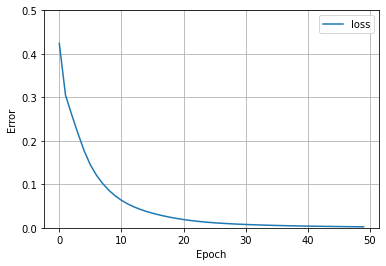

In [ ]:
plot_loss(history, ymin=0, ymax=0.5)

In [ ]:
# weight matrix of neurons that connect input layers to hidden layer
# get weight returns a list of weights and biases, by taking weight[0] you extract only the weights
weight_matrix = autoencoder.layers[1].get_weights()[0]
weight_matrix = np.asarray(weight_matrix)

def get_latent_context_AE():
    latent_context = np.empty(shape=(df.shape[0], n_latent_context))
    latent_context_labels = [f"latent_{x}" for x in range(n_latent_context)]
    
    # multiply each context sample for the weight matrix
    for idx, s in enumerate(df.loc[:, context_labels].values):
        latent_context[idx] = s @ weight_matrix
    
    # apply activation function
    latent_context = sigmoid(latent_context)
    df_latent_context = pd.DataFrame(latent_context, columns=latent_context_labels)

    return df_latent_context, latent_context_labels

####With PCA

In [ ]:
def get_latent_context_PCA(n_latent_context):
    latent_context_labels = [f"latent_{x}" for x in range(n_latent_context)]
    pca = PCA(n_components=n_latent_context)
    pca.fit(df.loc[:,context_labels])
    latent_context = pca.transform(df.loc[:,context_labels])  
    df_latent_context = pd.DataFrame(latent_context, columns=latent_context_labels)
    return df_latent_context, latent_context_labels

#### Run selected method

In [ ]:
method = 'AE'
if method == 'PCA': # latent context with PCA
    df_latent_context, latent_context_labels = get_latent_context_PCA(n_latent_context)
    df = pd.concat([df, df_latent_context], axis=1)
elif method == 'AE': # latent context with AE
    df_latent_context, latent_context_labels = get_latent_context_AE()
    df = pd.concat([df, df_latent_context], axis=1)
df

,user,item,cnt,daytime_afternoon,daytime_evening,daytime_morning,daytime_night,daytime_noon,daytime_sunrise,daytime_sunset,weekday_friday,weekday_monday,weekday_saturday,weekday_sunday,weekday_thursday,weekday_tuesday,weekday_wednesday,weather_cloudy,weather_drizzle,weather_foggy,weather_rainy,weather_sleet,weather_snowy,weather_stormy,weather_sunny,latent_0,latent_1,latent_2,latent_3,latent_4,latent_5,latent_6,latent_7,latent_8,latent_9,latent_10
0,0,0,0.000000,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0.293573,0.990041,0.038169,0.887627,0.286056,0.970688,0.033093,0.461438,0.681314,0.819436,0.943102
1,1,1,0.845098,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0.119790,0.128752,0.236433,0.672634,0.400051,0.003935,0.857416,0.993898,0.569574,0.926931,0.974347
2,2,2,0.778151,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0.953964,0.562305,0.961939,0.944961,0.569860,0.021671,0.579842,0.973792,0.959069,0.450816,0.035336
3,3,3,2.631444,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0.022863,0.355719,0.979278,0.394436,0.886207,0.987892,0.277858,0.018382,0.748206,0.787485,0.994953
4,4,4,0.778151,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0.644707,0.502079,0.196614,0.721885,0.706194,0.005819,0.012033,0.683930,0.024277,0.940264,0.919655
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83669,96,0,0.698970,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0.522980,0.985907,0.961325,0.957585,0.325165,0.961140,0.010876,0.433685,0.420863,0.264615,0.894561
83670,30,33,2.004321,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0.918482,0.118341,0.034709,0.863745,0.305730,0.890668,0.005122,0.979840,0.288622,0.221323,0.763790
83671,156,26,2.385606,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0.069297,0.299330,0.062626,0.847247,0.331723,0.933479,0.342035,0.987765,0.618369,0.465927,0.914665
83672,399,672,0.000000,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0.522980,0.985907,0.961325,0.957585,0.325165,0.961140,0.010876,0.433685,0.420863,0.264615,0.894561


### Hierarchical context extraction

In [ ]:
def is_leaf(node):
    return node.left is None and node.right is None

# Recursive function to find paths from root node to every leaf node of a binary tree
def root_leaf_paths(node, path, hierarchy):

    if node is None:
        return
 
    path.append(node.id)
 
    if is_leaf(node):
        hierarchy.append(list(path)) # append a complete path to the list of all paths
 
    # Call the functions on left and right subtrees
    root_leaf_paths(node.left, path, hierarchy)
    root_leaf_paths(node.right, path, hierarchy)
 
    # remove current node after left and right subtrees are done
    path.pop()

def hierarchical_clustering(df):
    linked = linkage(df, 'ward')  # linkage matrix
    rootnode, nodelist = to_tree(linked, rd=True) # tree representing the hierarchical clustering
    path = deque() # a path from the root node to a leaf
    hierarchy = []
    root_leaf_paths(rootnode, path, hierarchy)
    longest_path = len(max(hierarchy, key=len)) # find longest path from root to leaf
    hierarchy = [x + [x[-1]]*(longest_path - len(x)) for x in hierarchy] # make path of equal size
    hierarchy.sort(key=lambda x: x[-1]) # sort the list by the last element (datapoints id)
    return hierarchy

In [ ]:
hier_context = hierarchical_clustering(df.loc[:30, latent_context_labels])
hier_context

[[60, 59, 53, 51, 38, 0, 0, 0],
 [60, 59, 58, 54, 45, 36, 32, 1],
 [60, 57, 56, 48, 39, 2, 2, 2],
 [60, 57, 56, 52, 42, 3, 3, 3],
 [60, 59, 58, 55, 50, 44, 4, 4],
 [60, 59, 58, 54, 45, 36, 5, 5],
 [60, 59, 58, 55, 50, 34, 6, 6],
 [60, 59, 53, 51, 40, 7, 7, 7],
 [60, 59, 58, 55, 50, 34, 8, 8],
 [60, 57, 56, 52, 42, 9, 9, 9],
 [60, 59, 53, 51, 40, 10, 10, 10],
 [60, 59, 53, 51, 38, 31, 11, 11],
 [60, 59, 58, 54, 49, 41, 12, 12],
 [60, 57, 46, 37, 13, 13, 13, 13],
 [60, 59, 58, 54, 45, 14, 14, 14],
 [60, 59, 53, 47, 15, 15, 15, 15],
 [60, 59, 58, 54, 49, 41, 16, 16],
 [60, 59, 58, 55, 33, 17, 17, 17],
 [60, 59, 58, 54, 45, 36, 32, 18],
 [60, 57, 56, 48, 39, 19, 19, 19],
 [60, 57, 56, 48, 35, 20, 20, 20],
 [60, 57, 46, 43, 21, 21, 21, 21],
 [60, 57, 56, 48, 35, 22, 22, 22],
 [60, 59, 53, 47, 23, 23, 23, 23],
 [60, 59, 58, 55, 50, 44, 24, 24],
 [60, 59, 58, 54, 49, 25, 25, 25],
 [60, 59, 53, 51, 38, 31, 26, 26],
 [60, 59, 58, 55, 33, 27, 27, 27],
 [60, 57, 46, 43, 28, 28, 28, 28],
 [60, 57,

## Models

In [ ]:
# Dictionary that contain evaluation metrics for every model
models_eval_metrics = {}

### ECAM NCF

In [ ]:
def ncf(n_users, n_items, n_context, n_latent_factors_user, n_latent_factors_item):
    # inputs
    item_input = Input(shape=[1],name='item')
    user_input = Input(shape=[1],name='user')
    context_input = Input(shape=(n_context, ), name='context')

    # Item embedding
    item_embedding_mlp = Embedding(n_items + 1, n_latent_factors_item, name='item_embedding')(item_input)
    item_vec_mlp = Flatten(name='flatten_item')(item_embedding_mlp)

    # User embedding
    user_embedding_mlp = Embedding(n_users + 1, n_latent_factors_user,name='user_embedding')(user_input)
    user_vec_mlp = Flatten(name='flatten_user')(user_embedding_mlp)

    # Concat user embedding,item embeddings and context vector
    concat = Concatenate(name='user_item')([item_vec_mlp, user_vec_mlp, context_input])

    # dense layers
    dense = Dense(8, name='fully_connected_1')(concat)
    dense_2 = Dense(4, name='fully_connected_2')(dense)
    dense_3 = Dense(2, name='fully_connected_3')(dense_2)

    # Output
    pred_mlp = Dense(1, activation='relu', name='Activation')(dense_3)

    # make and build the model
    return keras.Model([user_input, item_input, context_input], pred_mlp)

In [ ]:
ecam_ncf = ncf(n_users, n_items, n_context, n_latent_factors_user, n_latent_factors_item)
opt = keras.optimizers.Adam(lr = 0.005)
ecam_ncf.compile(optimizer = opt,loss= 'mean_absolute_error', metrics=['mae', 'mse'])

#ecam_ncf.summary()
#tf.keras.utils.plot_model(ecam_ncf)

In [ ]:
rmse, mae = kfold_train(ecam_ncf, 15, 128, False, df, x_labels, y_label, context_labels, kf)
models_eval_metrics['ecam_ncf'] = [rmse, mae]
f'k-fold RMSE = {rmse}     k-fold MAE = {mae}'

Training on fold 0...
Testing on fold 0...
RMSE = 0.690984804837789    MAE = 0.5205652603508293
Training on fold 1...
Testing on fold 1...
RMSE = 0.6817304235883569    MAE = 0.5091107754694829
Training on fold 2...
Testing on fold 2...
RMSE = 0.6811248292461608    MAE = 0.5069081241962974


'k-fold RMSE = 0.6846133525574355     k-fold MAE = 0.5121947200055366'

### ECAM NeuMF

In [ ]:
# latent factors for matrix factorization
n_latent_factors_mf = 10

In [ ]:
def neumf(n_users, n_items, n_context, n_latent_factors_user, n_latent_factors_item, n_latent_factors_mf):
    # inputs
    item_input = Input(shape=[1],name='item')
    user_input = Input(shape=[1],name='user')
    context_input = Input(shape=(n_context, ), name='context')

    # item embedding MF
    item_embedding_mf = Embedding(n_items + 1, n_latent_factors_mf, name='item_embedding_MF')(item_input)
    item_vec_mf = Flatten(name='flatten_item_MF')(item_embedding_mf)

    # User embedding MF
    user_embedding_mf = Embedding(n_users + 1, n_latent_factors_mf,name='user_embedding_MF')(user_input)
    user_vec_mf = Flatten(name='flatten_user_MF')(user_embedding_mf)

    # Dot product MF
    dot = tf.keras.layers.Dot(axes=1)([user_vec_mf, item_vec_mf])

    # Item embedding MLP
    item_embedding_mlp = Embedding(n_items + 1, n_latent_factors_item, name='item_embedding_MLP')(item_input)
    item_vec_mlp = Flatten(name='flatten_item_MLP')(item_embedding_mlp)

    # User embedding MLP
    user_embedding_mlp = Embedding(n_users + 1, n_latent_factors_user,name='user_embedding_MLP')(user_input)
    user_vec_mlp = Flatten(name='flatten_user_MLP')(user_embedding_mlp)

    # Concat user embedding,item embeddings and context vector
    concat = Concatenate(name='user_item_context_MLP')([item_vec_mlp, user_vec_mlp, context_input])

    # dense layers
    dense = Dense(8, name='fully_connected_1')(concat)
    dense_2 = Dense(4, name='fully_connected_2')(dense)
    dense_3 = Dense(2, name='fully_connected_3')(dense_2)

    # concat MF and MLP
    concat_mf_mlp = Concatenate(name='MF_MLP')([dense_3, dot])

    # Output
    output = Dense(1, activation='relu',name='Activation')(concat_mf_mlp)

    # make and build the model
    return keras.Model([user_input, item_input, context_input], output)

In [ ]:
ecam_neumf = neumf(n_users, n_items, n_context, n_latent_factors_user, n_latent_factors_item, n_latent_factors_mf)
opt = keras.optimizers.Adam(lr = 0.005)
ecam_neumf.compile(optimizer = opt,loss= 'mean_absolute_error', metrics=['mae', 'mse'])

#ecam_neumf.summary()
#tf.keras.utils.plot_model(ecam_neumf)

In [ ]:
rmse, mae = kfold_train(ecam_neumf, 15, 128, False, df, x_labels, y_label, context_labels, kf)
models_eval_metrics['ecam_neumf'] = [rmse, mae]
f'k-fold RMSE = {rmse}     k-fold MAE = {mae}'

Training on fold 0...
Testing on fold 0...
RMSE = 0.6476278496653103    MAE = 0.48070578868287395
Training on fold 1...
Testing on fold 1...
RMSE = 0.6176490926921091    MAE = 0.4500932635796726
Training on fold 2...
Testing on fold 2...
RMSE = 0.6108303334818463    MAE = 0.4420926305196749


'k-fold RMSE = 0.6253690919464219     k-fold MAE = 0.45763056092740717'

### UCAM NCF

In [ ]:
ucam_ncf = ncf(n_users, n_items, n_latent_context, n_latent_factors_user, n_latent_factors_item)
opt = keras.optimizers.Adam(lr = 0.005)
ucam_ncf.compile(optimizer = opt,loss= 'mean_absolute_error', metrics=['mae', 'mse'])

#ucam_ncf.summary()
#tf.keras.utils.plot_model(ucam_ncf)

In [ ]:
rmse, mae = kfold_train(ucam_ncf, 15, 128, False, df, x_labels, y_label, latent_context_labels, kf)
models_eval_metrics['ucam_ncf'] = [rmse, mae]
f'k-fold RMSE = {rmse}     k-fold MAE = {mae}'

Training on fold 0...
Testing on fold 0...
RMSE = 0.6956431407137188    MAE = 0.5246989489099682
Training on fold 1...
Testing on fold 1...
RMSE = 0.6853388943665256    MAE = 0.5119693266892774
Training on fold 2...
Testing on fold 2...
RMSE = 0.6833072677446319    MAE = 0.5082299204903458


'k-fold RMSE = 0.6880964342749588     k-fold MAE = 0.5149660653631971'

### UCAM NeuMF

In [ ]:
ucam_neumf = neumf(n_users, n_items, n_latent_context, n_latent_factors_user, n_latent_factors_item, n_latent_factors_mf)
opt = keras.optimizers.Adam(lr = 0.005)
ucam_neumf.compile(optimizer = opt,loss= 'mean_absolute_error', metrics=['mae', 'mse'])

In [ ]:
rmse, mae = kfold_train(ucam_neumf, 15, 128, False, df, x_labels, y_label, latent_context_labels, kf)
models_eval_metrics['ucam_neumf'] = [rmse, mae]
f'k-fold RMSE = {rmse}     k-fold MAE = {mae}'

Training on fold 0...
Testing on fold 0...
RMSE = 0.645010366855807    MAE = 0.4795725899210981
Training on fold 1...
Testing on fold 1...
RMSE = 0.6226822737536651    MAE = 0.4536428949908698
Training on fold 2...
Testing on fold 2...
RMSE = 0.6146162807068933    MAE = 0.4450424098906223


'k-fold RMSE = 0.6274363071054552     k-fold MAE = 0.45941929826753003'

### Performance comparison

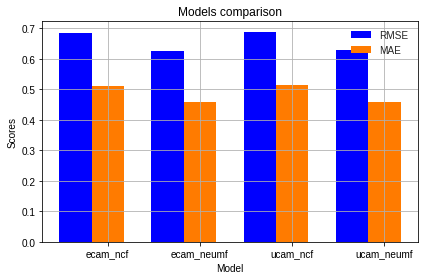

Name: ecam_ncf    	    MAE: 0.6846133525574355    	    RMSE: 0.5121947200055366
Name: ecam_neumf    	    MAE: 0.6253690919464219    	    RMSE: 0.45763056092740717
Name: ucam_ncf    	    MAE: 0.6880964342749588    	    RMSE: 0.5149660653631971
Name: ucam_neumf    	    MAE: 0.6274363071054552    	    RMSE: 0.45941929826753003


In [ ]:
n_models = 4 # number of different models
models_name = [x[0] for x in models_eval_metrics.items()] 
mae = [x[0] for x in models_eval_metrics.values()]
rmse = [x[1] for x in models_eval_metrics.values()]

fig, ax = plt.subplots()
index = np.arange(n_models)
bar_width = 0.35

# MAE bar
rect1 = plt.bar(index, mae, bar_width,
color='b',
label='RMSE')

# RMSE bar
rect2 = plt.bar(index + bar_width, rmse, bar_width,
color='#ff7b00',
label='MAE')

plt.style.use('seaborn-ticks') # readable chart on dark editor
plt.xlabel('Model')
plt.ylabel('Scores')
plt.title('Models comparison')
plt.xticks(index + bar_width, models_name)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

for name, mae, rmse in zip(models_name, mae, rmse):
    print(f"Name: {name}    \t    MAE: {mae}    \t    RMSE: {rmse}")